# `CNModel` Hyperfine Anomalies

Trey V. Wenger (c) December 2024

`CNModel` can also account for a full physical treatment of non-LTE effects. That is, it can model situations where the excitation temperature is *not* the same for each transition. `CNModel` considers the detailed balance between all transitions in the `mol_data` dictionary. For ${\rm CN}$ this includes all of the $N=1-0$ ($\nu = 0$) hyperfine transitions at 113.15 and 113.5 GHz, and for $^{13}{\rm CN}$ this includes all of the $N=1-0$ hyperfine transitions at 108.06 GHz, 108.4 GHz, 108.6 GHz, 108.8 GHz, and 109.2 GHz. Each state column density is a free parameter, and the relative state column densities are set by the excitation temperature. Since there are more transitions than states, this is an overconstrained problem and easy for a Bayesian forward model to solve.

Hyperfine anomalies are treated as deviations in the *log Boltzmann factor*, $\ln B = -h\nu/(k_B T_{\rm ex})$, from the value determined by the mean cloud excitation temperature, `log_boltz_factor_mean`. This parameterization is a modeling trick. Excitation temperature is defined by the Boltzmann factor

$B = \frac{g_l N_u}{g_u N_l} = e^{-h\nu / (k_B T_{\rm ex})}$

where $g$ and $N$ are the state degeneracies and column densities.

The "spread" of log Boltzmann factor anomalies is inferred by the `log_boltz_factor_sigma` parameter. Note that these parameters define the mean and spread of only the "free" transitions. Since there are more transitions than states, some of the transition excitation temperatures are derived from the others.

Note that while the mean cloud excitation temperature must be positive (since we specify the prior on the log excitation temperature), hyperfine anomalies can allow population inversions such that some transitions have *negative* excitation temperatures. This is a necessity since otherwise the parameter space becomes too confined for the MCMC sampler to efficiently explore. You should check that the model converges to a physically reasonable solution.

With these considerations in mind, the best way to model hyperfine anomalies generally is to (1) make the weak-LTE assumption such that the kinetic temperature is fixed to the mean cloud excitation temperature (this reduces the parameter space since the kinetic temperature is hard to constrain from the line width), (2) place a physically reasonable prior on the cloud mean excitation temperature, and (3) allow for hyperfine anomalies.

Here we demonstrate this in practice.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+5.gba85b08.dirty


## Simulate data

12CN-1 550
12CN-2 300
Transition 113144.19 is constraining upper state 4 from lower state 1
Transition 113191.325 is constraining upper state 0 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 2 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 4
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[ 3.25156488  4.71996872 17.69963438]
 [ 3.10572935  4.83113248 16.94592443]
 [ 3.49693365  4.73956147 16.52554688]
 [ 3.32884839  4.85160804 15.86709757]
 [ 3.51705843  4.43933718 16.09655952]
 [ 2.79796339  5.32908646 17.08152761]
 [ 3.31351584  4.99508744 16.87334157]
 [ 3.34752935  4.5372645  15.47295809]
 [ 3.16266653  5.11927756 1

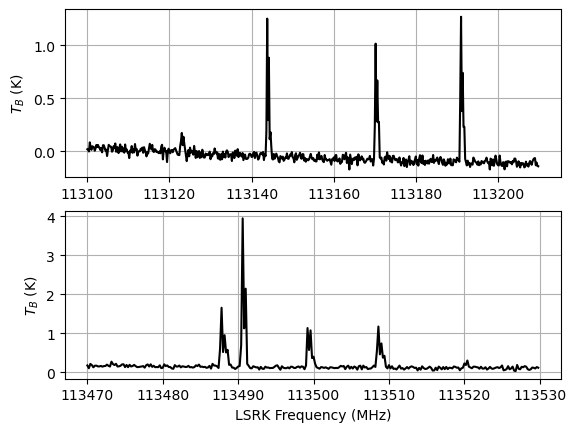

In [20]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_model import CNModel

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# CNModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = mean cloud excitation temperature
    prior_log_boltz_factor_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# here we specify the normalized log boltzmann factor offset for simplicity
rng = np.random.RandomState(seed=1234)
log_boltz_factor_sigma_norm = np.array([1.0, 0.75, 0.5])
log_boltz_factor_free_norm = log_boltz_factor_sigma_norm * rng.normal(size=(len(model.model.coords["transition_free"]), n_clouds))

sim_params = {
    "log10_N0": [13.5, 13.2, 12.8],
    "log10_Tkin": [0.5, 0.7, 1.2],
    "fwhm_nonthermal": [0.5, 0.2, 0.4],
    "velocity": [-1.0, 0.0, 1.0],
    "fwhm_L": 0.0,
    "baseline_12CN-1_norm": [-2.0, -5.0, 8.0],
    "baseline_12CN-2_norm": [4.0, -2.0, 5.0],
    "log_boltz_factor_sigma": 0.1 * log_boltz_factor_sigma_norm,
    "log_boltz_factor_free_norm": log_boltz_factor_free_norm,
}
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau = model.model.tau.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau:")
print(tau)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

## Model Definition

In [21]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.0, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = mean cloud excitation temperature
    prior_log_boltz_factor_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

12CN-1 550
12CN-2 300
Transition 113144.19 is constraining upper state 4 from lower state 1
Transition 113191.325 is constraining upper state 0 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 1 from lower state 1
Transition 113520.4215 is constraining upper state 2 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 4
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, velocity_norm]


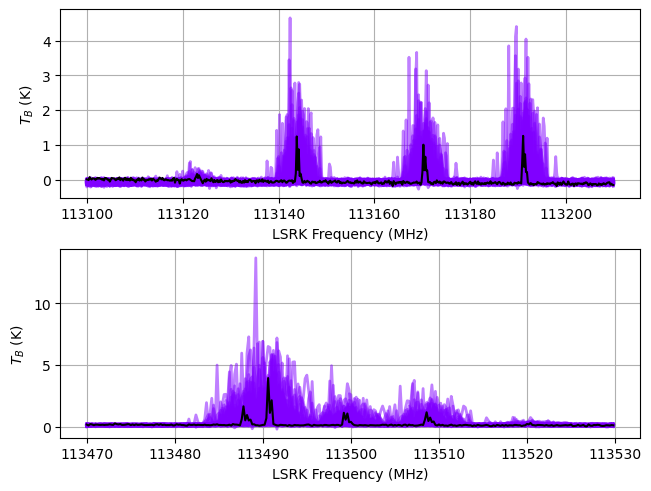

In [22]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [27]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4200
Interrupted at 4,199 [4%]: Average Loss = 3,810


Output()

Runtime: 0.84 minutes


In [28]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log10_N0[0]                12.861  0.004  12.855   12.868      0.000    0.000   
log10_N0[1]                12.678  0.016  12.651   12.710      0.001    0.000   
log10_N0[2]                12.805  0.007  12.793   12.818      0.000    0.000   
log10_Tkin[0]               1.124  0.005   1.116    1.133      0.000    0.000   
log10_Tkin[1]               0.684  0.010   0.664    0.701      0.000    0.000   
log10_Tkin[2]               0.895  0.006   0.884    0.905      0.000    0.000   
log10_Tex_mean[0]           1.124  0.005   1.116    1.133      0.000    0.000   
log10_Tex_mean[1]           0.684  0.010   0.664    0.701      0.000    0.000   
log10_Tex_mean[2]           0.895  0.006   0.884    0.905      0.000    0.000   
log_boltz_factor_sigma[0]   0.019  0.005   0.009    0.028      0.000    0.000   
log_boltz_factor_sigma[1]   0.269  0.019   0.233    0.303      0.001    0.000   
log_boltz_factor_sigma[2]   0.067  0.006   0.056    0.078      0.000    0.000   
log10_N[0]                 13.514  0.004  13.507   13.523      0.000    0.000   
log10_N[1]                 13.107  0.020  13.067   13.143      0.001    0.000   
log10_N[2]                 13.378  0.008  13.362   13.391      0.000    0.000   
velocity[0]                 1.002  0.005   0.994    1.011      0.000    0.000   
velocity[1]                -1.003  0.015  -1.030   -0.974      0.000    0.000   
velocity[2]                 0.012  0.007  -0.001    0.024      0.000    0.000   
fwhm_thermal[0]             0.153  0.001   0.152    0.155      0.000    0.000   
fwhm_thermal[1]             0.092  0.001   0.090    0.094      0.000    0.000   
fwhm_thermal[2]             0.118  0.001   0.116    0.119      0.000    0.000   
fwhm_nonthermal[0]          0.348  0.011   0.327    0.367      0.000    0.000   
fwhm_nonthermal[1]          0.627  0.058   0.524    0.740      0.002    0.001   
fwhm_nonthermal[2]          0.134  0.037   0.066    0.202      0.001    0.001   
fwhm[0]                     0.380  0.010   0.362    0.398      0.000    0.000   
fwhm[1]                     0.634  0.058   0.532    0.746      0.002    0.001   
fwhm[2]                     0.180  0.028   0.133    0.231      0.001    0.001   
tau_total[0]                0.362  0.009   0.346    0.380      0.000    0.000   
tau_total[1]                0.414  0.029   0.360    0.469      0.001    0.001   
tau_total[2]                0.471  0.017   0.442    0.505      0.001    0.000   
fwhm_L                      0.083  0.005   0.073    0.093      0.000    0.000   
baseline_12CN-1_norm[0]     0.025  0.048  -0.074    0.107      0.002    0.001   
baseline_12CN-1_norm[1]    -4.946  0.152  -5.199   -4.632      0.005    0.003   
baseline_12CN-1_norm[2]     3.036  0.706   1.615    4.231      0.023    0.016   
baseline_12CN-2_norm[0]    -0.332  0.065  -0.446   -0.204      0.002    0.001   
baseline_12CN-2_norm[1]    -1.988  0.201  -2.372   -1.635      0.006    0.005   
baseline_12CN-2_norm[2]     1.934  0.858   0.436    3.595      0.026    0.019   

                           ess_bulk  ess_tail  r_hat  
log10_N0[0]                  1012.0    1062.0    NaN  
log10_N0[1]                   964.0     981.0    NaN  
log10_N0[2]                   852.0     840.0    NaN  
log10_Tkin[0]                 828.0     916.0    NaN  
log10_Tkin[1]                 796.0     764.0    NaN  
log10_Tkin[2]                1064.0     910.0    NaN  
log10_Tex_mean[0]             828.0     916.0    NaN  
log10_Tex_mean[1]             796.0     764.0    NaN  
log10_Tex_mean[2]            1064.0     910.0    NaN  
log_boltz_factor_sigma[0]     998.0    1026.0    NaN  
log_boltz_factor_sigma[1]     986.0     949.0    NaN  
log_boltz_factor_sigma[2]    1005.0     870.0    NaN  
log10_N[0]                   1023.0    1025.0    NaN  
log10_N[1]                    943.0    1069.0    NaN  
log10_N[2]                    835.0     835.0    NaN  
velocity[0]                  1027.0     865.0    NaN  
velocity[1]    

Sampling: [12CN-1, 12CN-2]


Output()

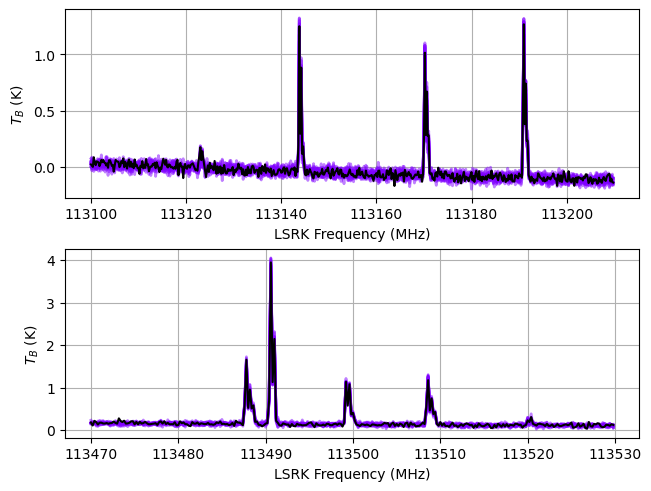

In [30]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [31]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4200
Interrupted at 4,199 [4%]: Average Loss = 3,810
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, log10_N0_norm, log10_Tkin_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1488 seconds.


Adding log-likelihood to trace


Output()

There were 52 divergences in converged chains.
Runtime: 26.08 minutes


In [32]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Sampling: [12CN-1, 12CN-2]


Output()

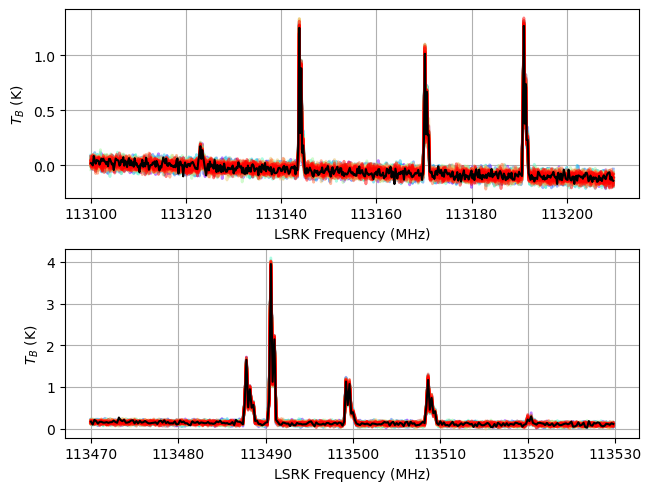

In [33]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [34]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log10_N0[0]                12.776  0.046  12.686   12.862      0.001    0.001   
log10_N0[1]                13.236  0.181  12.898   13.572      0.003    0.002   
log10_N0[2]                13.037  0.096  12.866   13.222      0.002    0.001   
log10_Tkin[0]               1.288  0.125   1.068    1.534      0.003    0.002   
log10_Tkin[1]               0.535  0.040   0.475    0.612      0.001    0.001   
log10_Tkin[2]               0.761  0.055   0.672    0.855      0.001    0.001   
log10_Tex_mean[0]           1.288  0.125   1.068    1.534      0.003    0.002   
log10_Tex_mean[1]           0.535  0.040   0.475    0.612      0.001    0.001   
log10_Tex_mean[2]           0.761  0.055   0.672    0.855      0.001    0.001   
log_boltz_factor_sigma[0]   0.029  0.022   0.000    0.067      0.000    0.000   
log_boltz_factor_sigma[1]   0.181  0.052   0.092    0.281      0.001    0.001   
log_boltz_factor_sigma[2]   0.066  0.027   0.023    0.117      0.000    0.000   
log10_N[0]                 13.463  0.025  13.415   13.507      0.001    0.000   
log10_N[1]                 13.597  0.169  13.288   13.919      0.003    0.002   
log10_N[2]                 13.547  0.073  13.411   13.687      0.001    0.001   
velocity[0]                 1.007  0.005   0.999    1.017      0.000    0.000   
velocity[1]                -0.989  0.015  -1.018   -0.962      0.000    0.000   
velocity[2]                 0.002  0.007  -0.012    0.014      0.000    0.000   
fwhm_thermal[0]             0.187  0.030   0.143    0.245      0.001    0.001   
fwhm_thermal[1]             0.078  0.004   0.072    0.085      0.000    0.000   
fwhm_thermal[2]             0.101  0.007   0.091    0.112      0.000    0.000   
fwhm_nonthermal[0]          0.370  0.021   0.335    0.404      0.000    0.000   
fwhm_nonthermal[1]          0.584  0.080   0.434    0.733      0.001    0.001   
fwhm_nonthermal[2]          0.160  0.066   0.017    0.262      0.001    0.001   
fwhm[0]                     0.415  0.016   0.384    0.445      0.000    0.000   
fwhm[1]                     0.589  0.079   0.440    0.737      0.001    0.001   
fwhm[2]                     0.193  0.053   0.094    0.275      0.001    0.001   
tau_total[0]                0.229  0.072   0.090    0.360      0.002    0.001   
tau_total[1]                2.126  0.960   0.555    3.891      0.014    0.010   
tau_total[2]                1.018  0.274   0.541    1.567      0.004    0.003   
fwhm_L                      0.023  0.017   0.000    0.054      0.000    0.000   
baseline_12CN-1_norm[0]     0.042  0.052  -0.058    0.137      0.001    0.000   
baseline_12CN-1_norm[1]    -4.905  0.147  -5.172   -4.629      0.001    0.001   
baseline_12CN-1_norm[2]     2.912  0.791   1.455    4.402      0.008    0.006   
baseline_12CN-2_norm[0]    -0.265  0.072  -0.394   -0.124      0.001    0.001   
baseline_12CN-2_norm[1]    -2.063  0.199  -2.437   -1.696      0.002    0.001   
baseline_12CN-2_norm[2]     1.553  0.887  -0.156    3.159      0.011    0.008   

                           ess_bulk  ess_tail  r_hat  
log10_N0[0]                  2543.0    1627.0    1.0  
log10_N0[1]                  4330.0    3874.0    1.0  
log10_N0[2]                  3584.0    3197.0    1.0  
log10_Tkin[0]                2401.0    1525.0    1.0  
log10_Tkin[1]                3370.0    3555.0    1.0  
log10_Tkin[2]                3721.0    3248.0    1.0  
log10_Tex_mean[0]            2401.0    1525.0    1.0  
log10_Tex_mean[1]            3370.0    3555.0    1.0  
log10_Tex_mean[2]            3721.0    3248.0    1.0  
log_boltz_factor_sigma[0]    1869.0    2109.0    1.0  
log_boltz_factor_sigma[1]    5199.0    5375.0    1.0  
log_boltz_factor_sigma[2]    3053.0    4438.0    1.0  
log10_N[0]                   2562.0    1606.0    1.0  
log10_N[1]                   4332.0    3838.0    1.0  
log10_N[2]                   3610.0    3235.0    1.0  
velocity[0]                  6924.0    6511.0    1.0  
velocity[1]    

['log10_N0_norm', 'log10_Tkin_norm', 'log_boltz_factor_sigma_norm', 'velocity_norm', 'fwhm_nonthermal_norm']


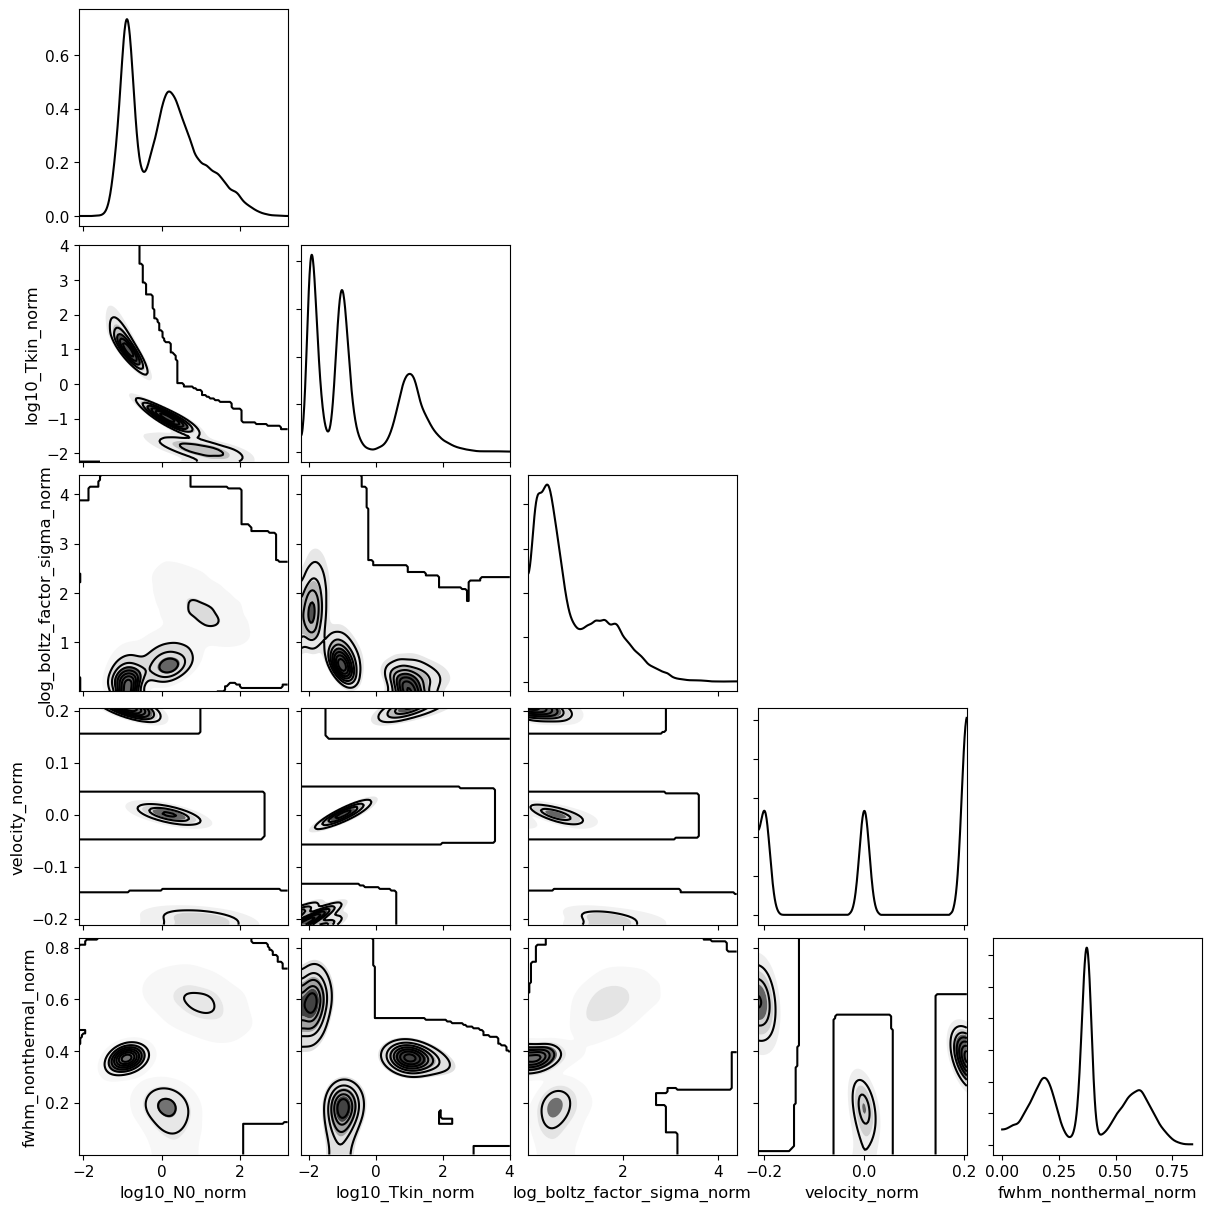

In [37]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_free"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

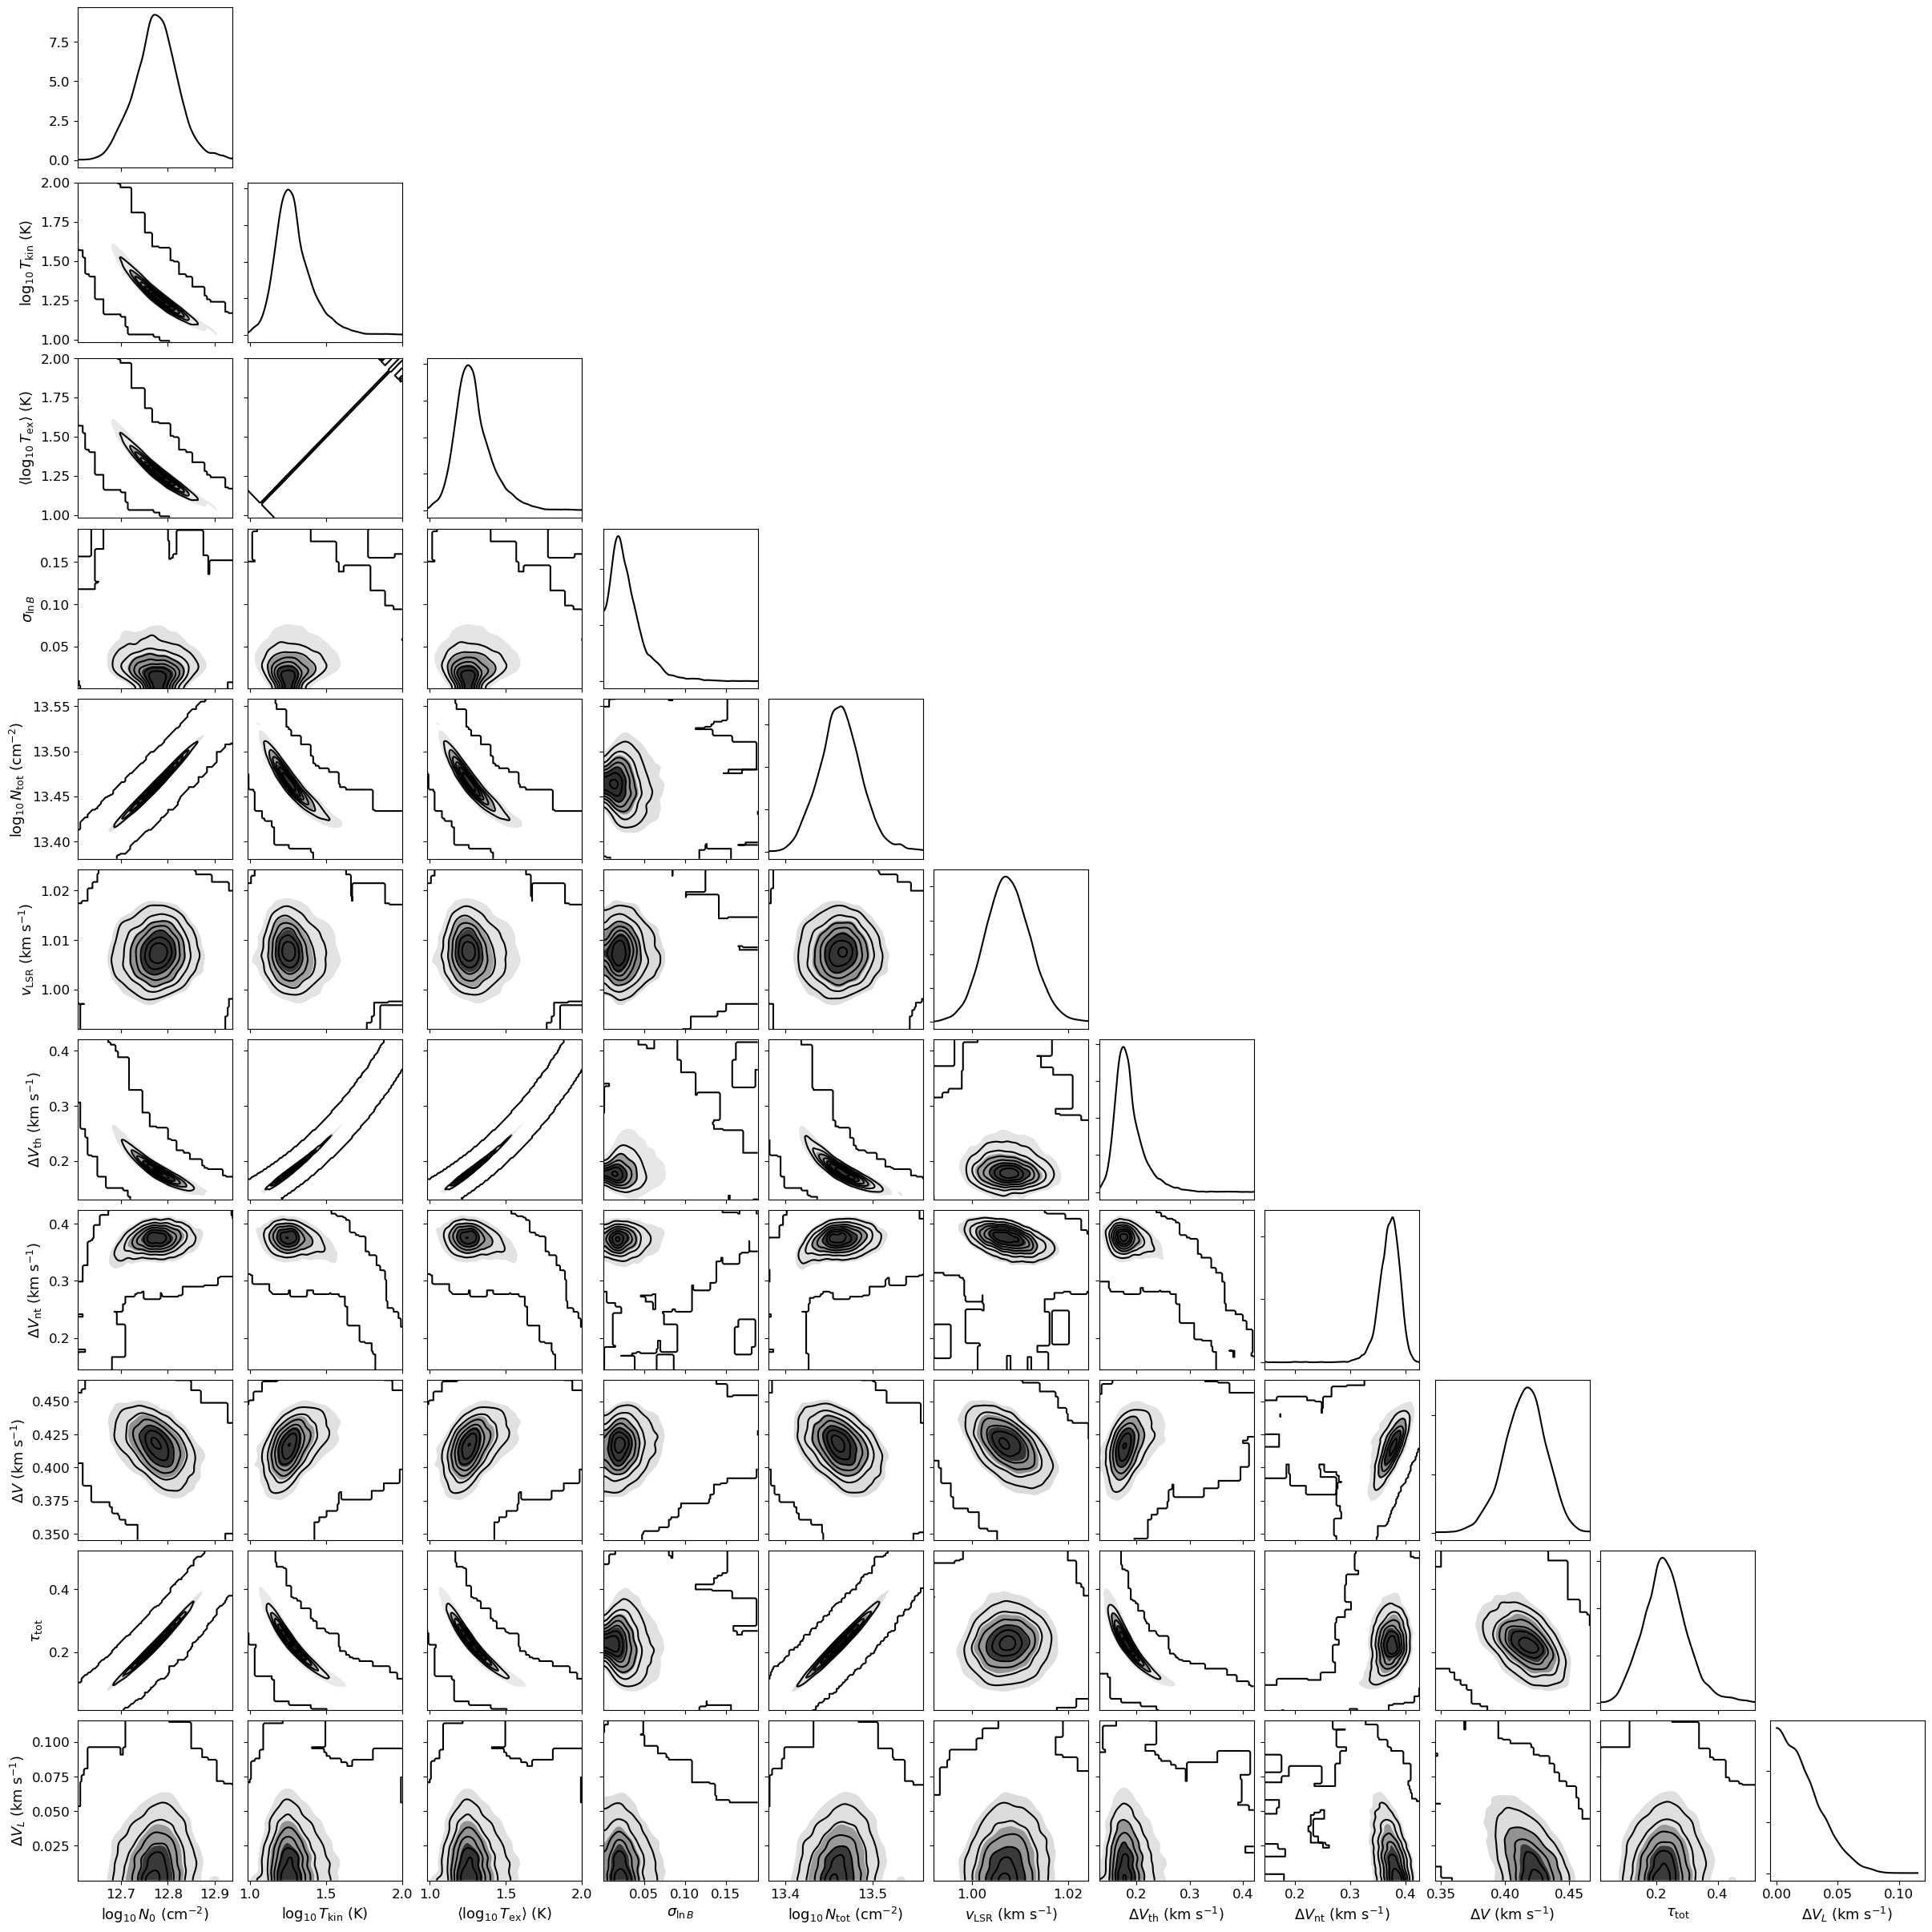

In [38]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "transition_free", "state_l", "state_u"]))
]
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

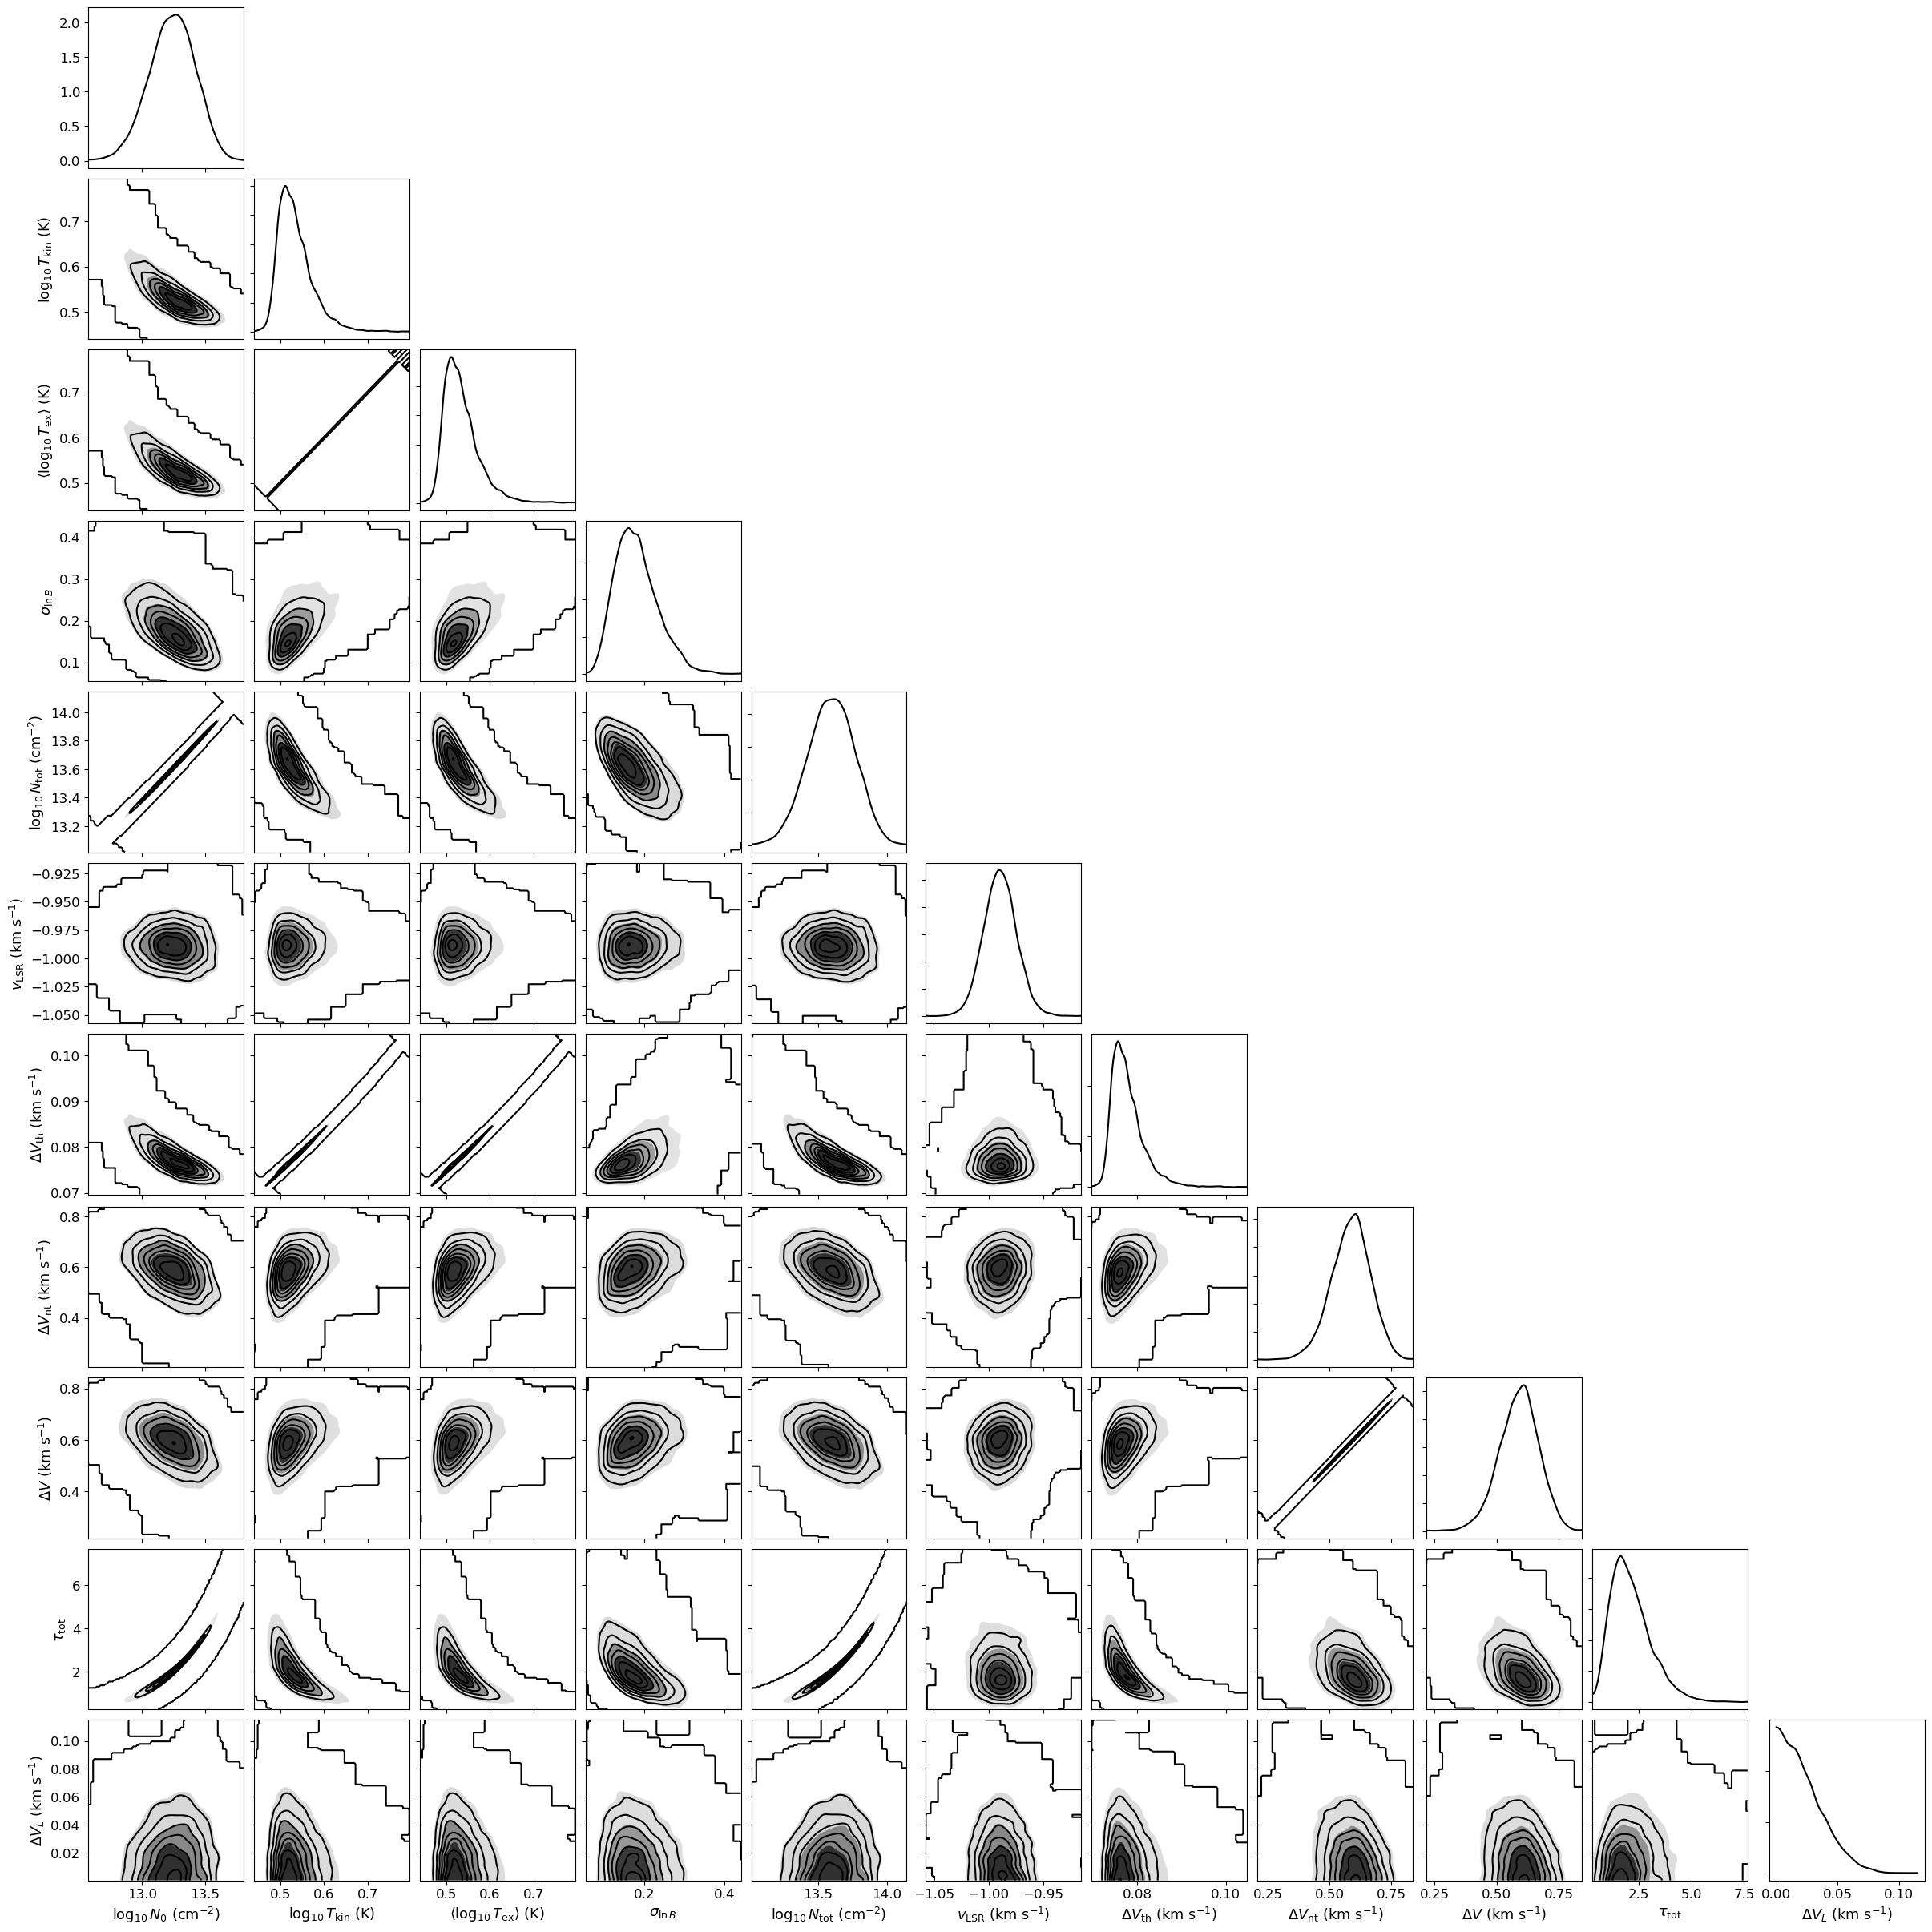

In [39]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

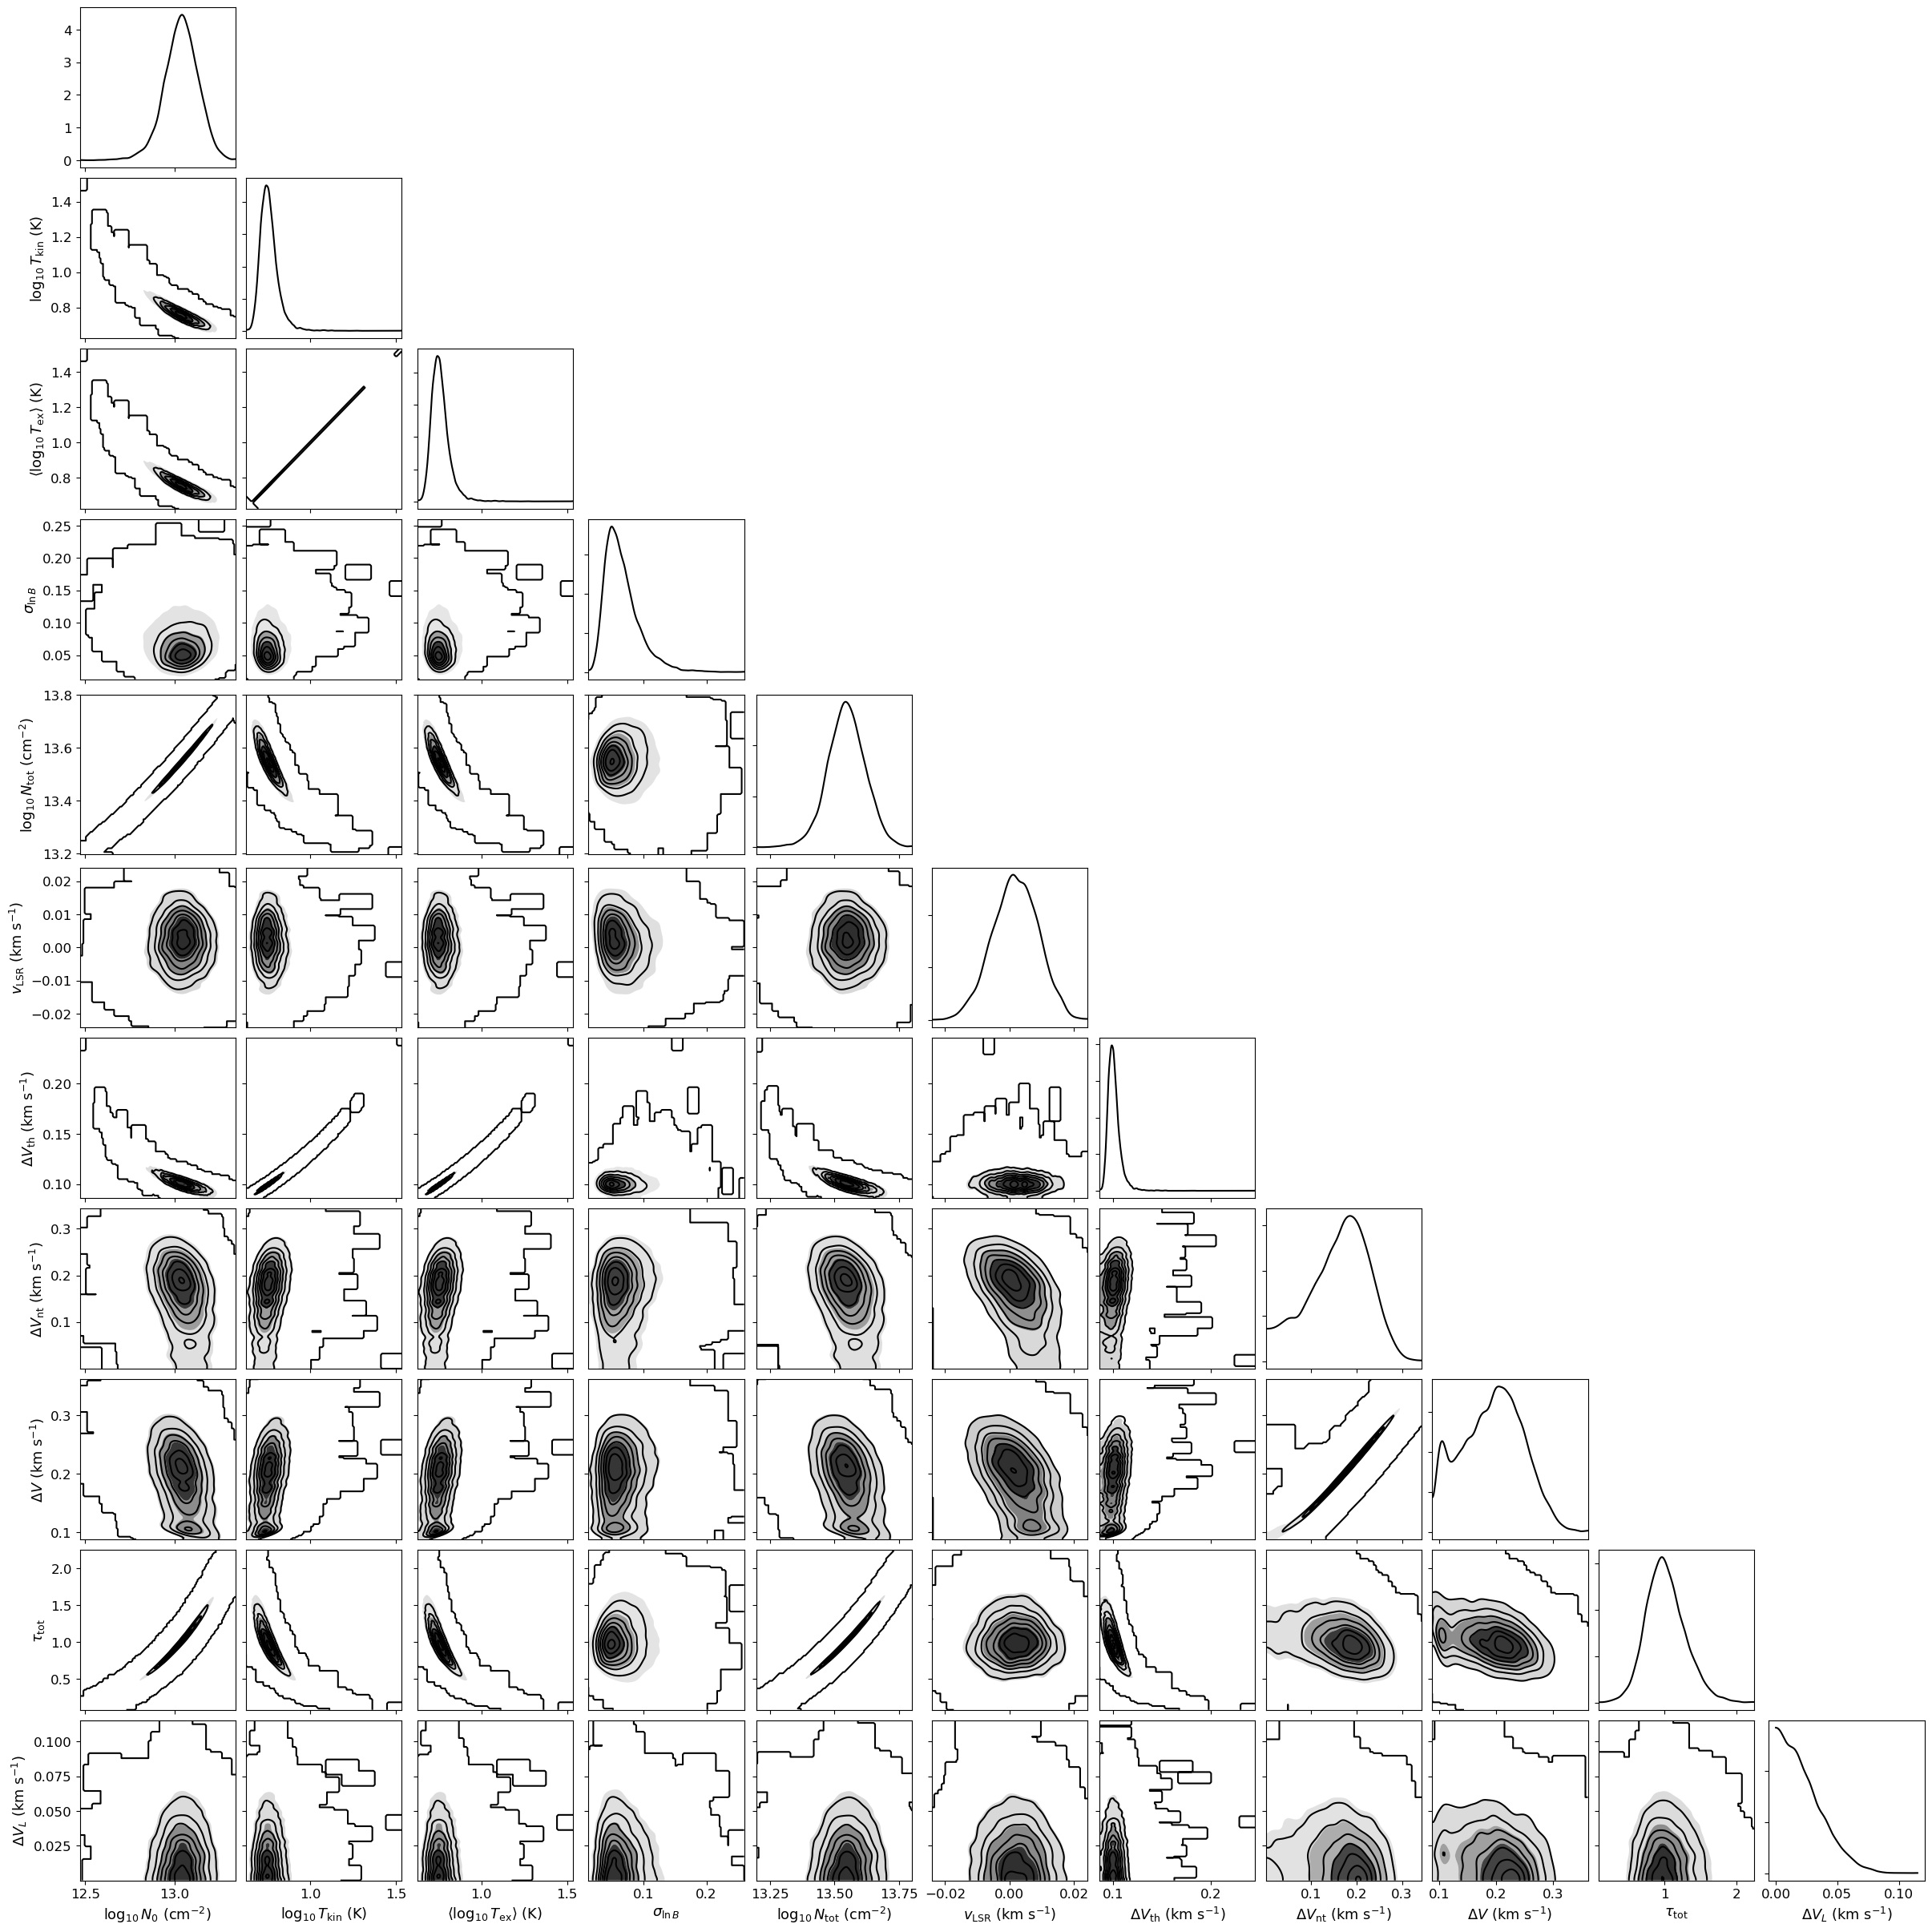

In [40]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [41]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3296.2279229173737


mean       sd  hdi_16%  hdi_84%
log10_N0[0]                            12.776    0.046   12.735   12.822
log10_N0[1]                            13.236    0.181   13.058   13.420
log10_N0[2]                            13.037    0.096   12.958   13.141
log10_Tkin[0]                           1.288    0.125    1.146    1.357
log10_Tkin[1]                           0.535    0.040    0.491    0.556
log10_Tkin[2]                           0.761    0.055    0.703    0.790
log10_Tex_mean[0]                       1.288    0.125    1.146    1.357
log10_Tex_mean[1]                       0.535    0.040    0.491    0.556
log10_Tex_mean[2]                       0.761    0.055    0.703    0.790
log_boltz_factor_sigma[0]               0.029    0.022    0.007    0.039
log_boltz_factor_sigma[1]               0.181    0.052    0.118    0.217
log_boltz_factor_sigma[2]               0.066    0.027    0.035    0.079
log_boltz_factor_mean[113123.3687, 0]  -0.291    0.075   -0.362   -0.219
log_boltz_factor_mean[113123.3687, 1]  -1.591    0.139   -1.747   -1.505
log_boltz_factor_mean[113123.3687, 2]  -0.949    0.109   -1.068   -0.873
log_boltz_factor_mean[113144.19, 0]    -0.291    0.075   -0.362   -0.219
log_boltz_factor_mean[113144.19, 1]    -1.592    0.139   -1.747   -1.505
log_boltz_factor_mean[113144.19, 2]    -0.949    0.109   -1.068   -0.873
log_boltz_factor_mean[113191.325, 0]   -0.291    0.075   -0.362   -0.219
log_boltz_factor_mean[113191.325, 1]   -1.592    0.139   -1.748   -1.506
log_boltz_factor_mean[113191.325, 2]   -0.950    0.109   -1.069   -0.873
log_boltz_factor_mean[113490.985, 0]   -0.292    0.076   -0.363   -0.220
log_boltz_factor_mean[113490.985, 1]   -1.597    0.140   -1.752   -1.510
log_boltz_factor_mean[113490.985, 2]   -0.952    0.109   -1.071   -0.876
log_boltz_factor_mean[113508.934, 0]   -0.292    0.076   -0.363   -0.220
log_boltz_factor_mean[113508.934, 1]   -1.597    0.140   -1.752   -1.510
log_boltz_factor_mean[113508.934, 2]   -0.953    0.109   -1.072   -0.876
log_boltz_factor_mean[113520.4215, 0]  -0.292    0.076   -0.364   -0.220
log_boltz_factor_mean[113520.4215, 1]  -1.597    0.140   -1.753   -1.510
log_boltz_factor_mean[113520.4215, 2]  -0.953    0.109   -1.072   -0.876
log_boltz_factor_free[113123.3687, 0]  -0.278    0.083   -0.364   -0.208
log_boltz_factor_free[113123.3687, 1]  -1.456    0.178   -1.656   -1.365
log_boltz_factor_free[113123.3687, 2]  -0.958    0.117   -1.076   -0.862
log_boltz_factor_free[113144.19, 0]    -0.270    0.081   -0.356   -0.202
log_boltz_factor_free[113144.19, 1]    -1.610    0.116   -1.754   -1.554
log_boltz_factor_free[113144.19, 2]    -0.957    0.114   -1.078   -0.869
log_boltz_factor_free[113191.325, 0]   -0.294    0.078   -0.370   -0.222
log_boltz_factor_free[113191.325, 1]   -1.452    0.144   -1.634   -1.383
log_boltz_factor_free[113191.325, 2]   -0.940    0.117   -1.069   -0.855
log_boltz_factor_free[113490.985, 0]   -0.294    0.061   -0.352   -0.234
log_boltz_factor_free[113490.985, 1]   -1.989    0.031   -2.017   -1.958
log_boltz_factor_free[113490.985, 2]   -0.933    0.061   -1.002   -0.900
log_boltz_factor_free[113508.934, 0]   -0.286    0.079   -0.369   -0.219
log_boltz_factor_free[113508.934, 1]   -1.470    0.141   -1.645   -1.401
log_boltz_factor_free[113508.934, 2]   -1.034    0.111   -1.148   -0.944
log_boltz_factor_free[113520.4215, 0]  -0.318    0.080   -0.388   -0.238
log_boltz_factor_free[113520.4215, 1]  -1.681    0.111   -1.815   -1.627
log_boltz_factor_free[113520.4215, 2]  -0.899    0.122   -1.038   -0.817
log_boltz_factor[113123.3687, 0]       -0.278    0.083   -0.364   -0.208
log_boltz_factor[113123.3687, 1]       -1.456    0.178   -1.656   -1.365
log_boltz_factor[113123.3687, 2]       -0.958    0.117   -1.076   -0.862
log_boltz_factor[113144.19, 0]         -0.270    0.081   -0.356   -0.202
log_boltz_factor[113144.19, 1]         -1.610    0.116   -1.754   -1.554
log_boltz_factor[113144.19, 2]         -0.957    0.114   -1.078   -0.869
log_boltz_factor[113170.53

In [42]:
print(sim_params)
print(derived_params)

{'log10_N0': [13.5, 13.2, 12.8], 'log10_Tkin': [0.5, 0.7, 1.2], 'fwhm_nonthermal': [0.5, 0.2, 0.4], 'velocity': [-1.0, 0.0, 1.0], 'fwhm_L': 0.0, 'baseline_12CN-1_norm': [-2.0, -5.0, 8.0], 'baseline_12CN-2_norm': [4.0, -2.0, 5.0], 'log_boltz_factor_sigma': array([0.1  , 0.075, 0.05 ]), 'log_boltz_factor_free_norm': array([[ 4.71435164e-01, -8.93231771e-01,  7.16353484e-01],
       [-3.12651896e-01, -5.40441550e-01,  4.43581470e-01],
       [ 8.59588414e-01, -4.77392628e-01,  7.84818606e-03],
       [-2.24268495e+00,  8.62526794e-01,  4.95973011e-01],
       [ 9.53324128e-01, -1.51594112e+00, -1.67038683e-01],
       [ 2.11836468e-03,  3.04090059e-01,  1.44545970e-01]])}
{'log10_N': array([13.85113973, 13.67935204, 13.4736674 ]), 'tau_total': array([3.7210465 , 1.57189983, 0.25869209])}


In [43]:
az.summary(model.trace.solution_0, var_names=["log_boltz_factor_free_norm"], kind='stats', hdi_prob=0.68)

mean     sd  hdi_16%  hdi_84%
log_boltz_factor_free_norm[113123.3687, 0]  0.263  0.938   -0.607    1.220
log_boltz_factor_free_norm[113123.3687, 1]  0.763  0.547    0.259    1.346
log_boltz_factor_free_norm[113123.3687, 2] -0.140  0.733   -0.885    0.542
log_boltz_factor_free_norm[113144.19, 0]    0.771  0.711    0.097    1.414
log_boltz_factor_free_norm[113144.19, 1]   -0.100  0.432   -0.510    0.350
log_boltz_factor_free_norm[113144.19, 2]   -0.122  0.498   -0.624    0.340
log_boltz_factor_free_norm[113191.325, 0]  -0.113  0.678   -0.709    0.572
log_boltz_factor_free_norm[113191.325, 1]   0.820  0.481    0.287    1.242
log_boltz_factor_free_norm[113191.325, 2]   0.199  0.582   -0.446    0.682
log_boltz_factor_free_norm[113490.985, 0]  -0.087  0.776   -0.871    0.595
log_boltz_factor_free_norm[113490.985, 1]  -2.219  0.648   -2.801   -1.514
log_boltz_factor_free_norm[113490.985, 2]   0.341  0.862   -0.512    1.175
log_boltz_factor_free_norm[113508.934, 0]   0.239  0.685   -0.409    0.877
log_boltz_factor_free_norm[113508.934, 1]   0.747  0.481    0.256    1.207
log_boltz_factor_free_norm[113508.934, 2]  -1.374  0.661   -1.993   -0.691
log_boltz_factor_free_norm[113520.4215, 0] -0.924  0.781   -1.678   -0.176
log_boltz_factor_free_norm[113520.4215, 1] -0.470  0.476   -0.928    0.014
log_boltz_factor_free_norm[113520.4215, 2]  0.910  0.667    0.231    1.550